In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division
import numpy as np
import pandas as pd
import gensim.corpora as corpora
import json
import random
import sys
import copy
import nltk
import seaborn as sns
sys.path.append('..')
from helpers.glove_neighbors import *
from helpers.funcs import *
from gensim.utils import SaveLoad

In [2]:
config = json.load(open('../config.json', 'r'))
MALLET = config['MALLET']
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
RNG = random.Random()
RNG.seed(config['SEED'])
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
K_VALS = range(6, 11)
sno = nltk.stem.SnowballStemmer('english')

In [3]:
NO_SAMPLES = 400

In [4]:
# use the same set of topic ids across the two models and tasks
SAMPLE_TOPIC_IDS = {num_topics: RNG.choices(range(num_topics), k=NO_SAMPLES) for num_topics in K_VALS}

In [5]:
def get_furthest_other_closest(furthest, closest):
    # keep words that are in `furthest` but also in `closest` for another cluster
    for i, items in furthest.items():
        closest_other = set()
        for j, items_other in closest.items():
            if j == i:
                continue
            closest_other |= items_other

        new_list = []
        for k in items:
            if k in closest_other:
                new_list.append(k)
        furthest[i] = new_list
    return furthest

## Check proportion of tweets dropped per event after filtering

In [9]:
event_list = []
prop_dropped = []
k_list = []
model_list = []

for model in ['kmeans', 'btm', 'mallet']:
    for k in K_VALS:
        print(k)
        for j, event in enumerate(events):
            df = pd.read_csv(TWEET_DIR + event + '/' + event + '_'+model+'_topics_' + str(k) + '.csv')
            if model == 'kmeans':
                thresholds = json.load(open(OUTPUT_DIR + 'cosine_thresholds.json', 'r'))
                df['ratio']  = df['cosine_0'] / df['cosine_1']
            else:
                thresholds = json.load(open(OUTPUT_DIR + 'prob_thresholds_'+model+'.json', 'r'))
                df['ratio'] = (1 - df['prob_0']) / (1 - df['prob_1'])
            orig = len(df)
            df = df[df['ratio'] < thresholds[str(k)]]
            prop_dropped.append(1 - (len(df) / orig))
            event_list.append(event)
            k_list.append(k)
            model_list.append(model)

df = pd.DataFrame.from_dict({'event':event_list, 'k':k_list, 'prop':prop_dropped, 'model': model_list})

6
7
8
9
10
6
7
8
9
10
6
7
8
9
10


In [10]:
print(df.prop.min(), df.prop.max())

0.0993988536278485 0.3368055555555556


In [11]:
df['prop'].mean()

0.23024718323574178

In [13]:
df['prop'].std()

0.039940228078748585

In [23]:
df[(df['model'] == 'kmeans') & (df['k'] == 8)].prop.min()

0.10822089303101956

In [24]:
df[(df['model'] == 'kmeans') & (df['k'] == 8)].prop.max()

0.2665271378496946

In [27]:
df[(df['model'] == 'kmeans') & (df['k'] == 8)].mean()

k       8.000000
prop    0.215463
dtype: float64

In [28]:
df[(df['model'] == 'kmeans') & (df['k'] == 8)].std()

k       0.000000
prop    0.035014
dtype: float64

## Check how are clusters represented in the events

In [75]:
def get_df(model):
    event_list = []
    topic_list = []
    topic_prop_list = []
    k_list = []

    event_props = {(k, e): 0 for k in K_VALS for e in events}
    k_total = {k: 0 for k in K_VALS}

    for k in K_VALS:
        topic_words = json.load(open(OUTPUT_DIR + model + '_'+str(k)+'_words.json', 'r'))
        print(k)
        for j, event in enumerate(events):
            df = pd.read_csv(TWEET_DIR + event + '/' + event + '_'+model+'_topics_' + str(k) + '.csv')
            if model == 'kmeans':
                thresholds = json.load(open(OUTPUT_DIR + 'cosine_thresholds.json', 'r'))
                df['ratio']  = df['cosine_0'] / df['cosine_1']
            else:
                thresholds = json.load(open(OUTPUT_DIR + 'prob_thresholds_'+model+'.json', 'r'))
                df['ratio'] = (1 - df['prob_0']) / (1 - df['prob_1'])
            df = df[df['ratio'] < thresholds[str(k)]]
            total_props = np.bincount(df['topic_0']) / np.sum(np.bincount(df['topic_0']))
            for i in range(k):
                event_list.append(event)
                topic_list.append(i)
                topic_prop_list.append(total_props[i])
                k_list.append(k)
            event_props[(k, event)] = len(df)
            k_total[k] += len(df)
    event_props_div = {}
    for k, v in event_props.items():
        event_props_div[k] = v / k_total[k[0]]
    event_prop_list = []
    for k in K_VALS:
        for e in events:
            for _ in range(k):
                event_prop_list.append(event_props_div[k, e])
    df = pd.DataFrame.from_dict({'event':event_list, 'k':k_list, 'topic':topic_list, 'topic_prop':topic_prop_list, 'event_prop':event_prop_list})
    df['repr'] = df['topic_prop'] / df['event_prop']
    return df

In [76]:
kmeans = get_df('kmeans')

6
7
8
9
10


In [77]:
btm = get_df('btm')

6
7
8
9
10


In [78]:
mallet = get_df('btm')

6
7
8
9
10


In [79]:
kmeans['model'] = 'kmeans'
btm['model'] = 'btm'
mallet['model'] = 'mallet'
all_data = pd.concat([kmeans, btm, mallet], ignore_index=True)

Text(790.73,0.5,'')

<Figure size 3000x3000 with 0 Axes>

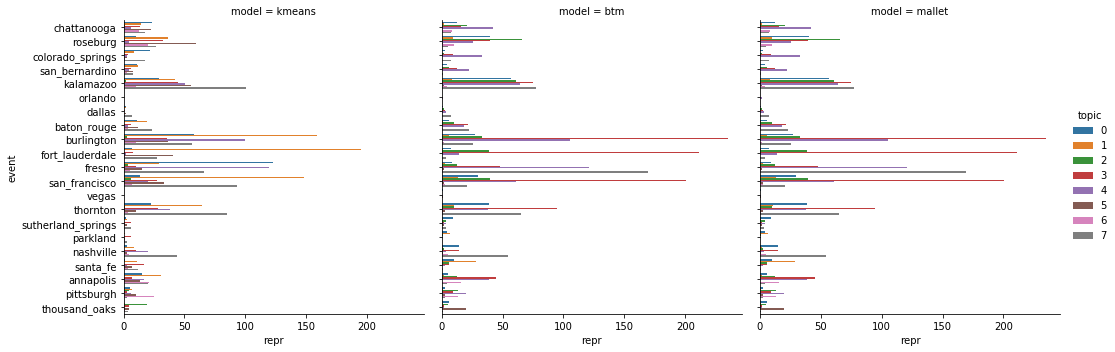

In [85]:
f = plt.figure(figsize=(10,10), dpi=300)
k = 8
s = all_data[all_data['k'] == k]
sns.catplot(x='repr', y='event', hue='topic', col='model', kind='bar', data=s)
plt.ylabel('')

In [90]:
event = 'sutherland_springs'
cluster_method='relative'
data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                   usecols=['user_id', 'text'])
data = get_cluster_assignments(event, data, cluster_method)
for t in data[data['topic']==2].sample(30).text:
    print(t)

Church shooting in Fresno, California too
Per @AP #SutherlandSprings Pastor's wife: she and husband were out of town during shooting but daughter among dead
Hmmm killed 2 dozen in a church. What a mystery.
Texans, you are blessed to have Mattress Mack & Stephen Willeford. Man who shot Texas church gunman shares his story
New video by CBS News: Pastor's daughter among those killed in Texas church shooting
Texas Church Massacre Is Fifth Deadliest Shooting in America's History
New post: Church Shooting Leaves Texas School Devastated
More people died in the Texas Church Massacre than the Texas Chainsaw Massacre.
TEXAS CHURCH MASSACRE 27 DEAD; 30 INJURED GUNMAN IN FULL COMBAT GEAR
Northern Michigan couple among those killed in Texas church shooting
Sheriff: 12 to 14 children are among the victims of the Texas church shooting
26 killed in church attack in Texas' deadliest mass shooting - Kansas City Star
Texas church shooting survivor watched gunman shoot woman next to her
Including church a

# Word intrusion

In [51]:
LOWEST_PERCENTILE = 5
NUM_CLOSE = 5

In [52]:
def generate_samples(k, closest_10, furthest, dicts):
    for i in range(NO_SAMPLES):
        d = {}
        topic_id = SAMPLE_TOPIC_IDS[k][i]  # topic_id for sample
        keywords = RNG.sample(closest_10[topic_id], NUM_CLOSE).copy()
        sampled_word = RNG.choice(furthest[topic_id])
        
        # construct sample
        keywords.append(sampled_word)
        shuffled_idx = list(range(len(keywords)))
        RNG.shuffle(shuffled_idx)
        odd_idx = shuffled_idx.index(NUM_CLOSE)
        d['odd_idx'] = odd_idx
        for j, idx in enumerate(shuffled_idx):
            d['word_' + str(j)] = keywords[idx]
        d['topic'] = topic_id
        d['no_topics'] = k
        d['sample_idx'] = i
        dicts.append(d)
    return dicts

## kmeans model

In [8]:
glove = pd.read_csv(OUTPUT_DIR+'glove.50d.csv', sep='\t', index_col=0)

In [9]:
stopwords = set([sno.stem(w) for w in open(INPUT_DIR + 'stopwords.txt', 'r').read().splitlines()])
glove = glove[~glove.index.isin(stopwords)]

In [10]:
V = len(glove)
V_lowest = int(V / 100 * LOWEST_PERCENTILE)
V_lowest

83

In [11]:
dicts = []
for k in K_VALS:
    print(k, 'clusters')
    means = np.load(OUTPUT_DIR + 'cluster_'+str(k)+'_means.npy')
    
    # get closest words to each cluster
    closest_10 = {i: list(neighbors_vector(m, glove).head(10).index) for i, m in enumerate(means)} # this is a list
    print(closest_10)
    closest = {i: set(neighbors_vector(m, glove).head(V_lowest).index) for i, m in enumerate(means)}
    
    # get furthest words to each cluster within LOWEST_PERCENTILE percentile
    furthest = {i: list(neighbors_vector(m, glove).tail(V_lowest).index) for i, m in enumerate(means)}
    furthest = get_furthest_other_closest(furthest, closest)
    
    # generate samples
    dicts = generate_samples(k, closest_10, furthest, dicts)
kmeans_df = pd.DataFrame(dicts, index = range(len(dicts)))

6 clusters
{0: ['racist', 'extremist', 'blm', 'label', 'radic', '#blm', 'racism', 'thug', '#blacklivesmatt', 'supremacist'], 1: ['#break', 'custodi', '#breakingnew', '#updat', 'fatal', 'confirm', 'updat', 'unconfirm', 'multipl', 'detain'], 2: ['affect', 'senseless', 'ach', 'heart', 'heartbroken', 'sadden', 'pray', 'faculti', '#prayer', 'prayer'], 3: ['argument', 'eat', 'yeah', 'fix', 'kid', 'solv', '#gunreformnow', 'problem', '#guncontolnow', 'bad'], 4: ['bar', 'calif', 'california', 'thousand', 'identifi', 'veteran', 'southern', 'david', 'los', 'gunman'], 5: ['honor', 'tuesday', 'memori', 'candlelight', 'flown', 'vigil', 'capitol', 'gather', 'observ', 'honour']}
7 clusters
{0: ['racist', 'blm', 'extremist', 'label', '#blm', '#blacklivesmatt', 'thug', 'racism', 'radic', 'rhetor'], 1: ['#break', 'custodi', '#breakingnew', '#updat', 'confirm', 'fatal', 'multipl', 'updat', 'unconfirm', 'evacu'], 2: ['affect', 'senseless', 'ach', 'heart', 'heartbroken', 'sadden', 'pray', 'faculti', '#praye

## Mallet

In [64]:
topic_words = SaveLoad.load(OUTPUT_DIR + 'ldamallet_model_6.pickle').get_topics()
V = topic_words.shape[1]
V_lowest = int(V / 100 * LOWEST_PERCENTILE)
V_lowest

83

In [65]:
dicts = []
for k in K_VALS:
    print(k, 'clusters')
    ldamallet = SaveLoad.load(OUTPUT_DIR + 'ldamallet_model_' + str(k) + '.pickle')
    topic_words = ldamallet.get_topics()
    id2word = ldamallet.id2word
    
    # get closest words to each cluster
    closest_10 = {i: [id2word.id2token[idx] for idx in row.argsort()[::-1][:10]] for i, row in enumerate(topic_words)} # list
    print(closest_10)
    with open(OUTPUT_DIR + 'mallet_' + str(k) + '_words.json', 'w') as f:
        f.write(json.dumps({k: ', '.join(v) for k, v in closest_10.items()}))
        
    closest = {i: set([id2word.id2token[idx] for idx in row.argsort()[::-1][:V_lowest]]) for i, row in enumerate(topic_words)}  # set
    
    # get furthest words to each cluster within LOWEST_PERCENTILE percentile
    furthest = {i: [id2word.id2token[idx] for idx in row.argsort()[:V_lowest]] for i, row in enumerate(topic_words)}
    furthest = get_furthest_other_closest(furthest, closest)
    
    # generate samples
    dicts = generate_samples(k, closest_10, furthest, dicts)
mallet_df = pd.DataFrame(dicts, index = range(len(dicts)))

6 clusters
{0: ['shoot', 'school', 'high', 'trump', 'day', 'texa', 'parkland', 'year', 'student', 'massacr'], 1: ['shoot', 'polic', 'dead', 'shot', 'report', 'suspect', 'offic', 'news', 'gunman', 'airport'], 2: ['kill', 'peopl', 'hous', 'white', 'live', 'dalla', 'man', 'guy', 'cop', 'black'], 3: ['shooter', 'attack', 'san', 'orlando', 'terrorist', 'plan', 'bernardino', 'call', 'terror', 'obama'], 4: ['gun', 'church', 'stop', 'control', 'law', 'time', 'violenc', 'make', 'talk', 'good'], 5: ['shoot', 'victim', 'mass', 'famili', 'prayer', 'vega', 'today', 'thought', 'thousand', 'las']}
7 clusters
{0: ['kill', 'peopl', 'polic', 'shot', 'white', 'offic', 'dalla', 'colorado', 'cop', 'suspect'], 1: ['shoot', 'victim', 'famili', 'prayer', 'today', 'mass', 'thought', 'thousand', 'life', 'communiti'], 2: ['shoot', 'vega', 'las', 'day', 'massacr', 'mass', 'time', 'year', 'die', 'parkland'], 3: ['shooter', 'hous', 'church', 'murder', 'killer', 'live', 'hero', 'tweet', 'person', 'back'], 4: ['gun',

## BTM

In [62]:
word2idx = json.load(open(OUTPUT_DIR + 'joint_vocab_nostop.json', 'r'))
idx2word = {i: w for w, i in word2idx.items()}
V = len(word2idx)
V_lowest = int(V / 100 * LOWEST_PERCENTILE)
V_lowest

83

In [63]:
dicts = []
for k in K_VALS:
    print(k, 'clusters')
    topic_words = np.load(OUTPUT_DIR + 'btm_' + str(k) + '_topic_words.npy')
    
    # get closest words to each cluster
    closest_10 = {i: [idx2word[idx] for idx in row.argsort()[::-1][:10]] for i, row in enumerate(topic_words)} # list
    with open(OUTPUT_DIR + 'btm_' + str(k) + '_words.json', 'w') as f:
        f.write(json.dumps({k: ', '.join(v) for k, v in closest_10.items()}))
    
    print(closest_10)
    closest = {i: set([idx2word[idx] for idx in row.argsort()[::-1][:V_lowest]]) for i, row in enumerate(topic_words)}  # set
    
    # get furthest words to each cluster within LOWEST_PERCENTILE percentile
    furthest = {i: [idx2word[idx] for idx in row.argsort()[:V_lowest]] for i, row in enumerate(topic_words)}
    furthest = get_furthest_other_closest(furthest, closest)
    
    # generate samples
    dicts = generate_samples(k, closest_10, furthest, dicts)
btm_df = pd.DataFrame(dicts, index = range(len(dicts)))

6 clusters
{0: ['shoot', 'shooter', 'attack', 'trump', 'san', 'vega', 'gun', 'bernardino', 'orlando', 'victim'], 1: ['kill', 'peopl', 'shoot', 'white', 'shooter', 'shot', 'polic', 'gun', 'dalla', 'black'], 2: ['gun', 'school', 'shoot', 'high', 'law', 'peopl', 'control', 'church', 'parkland', 'student'], 3: ['shoot', 'victim', 'famili', 'prayer', 'thought', 'kill', 'today', 'mass', 'communiti', 'heart'], 4: ['shoot', 'dead', 'polic', 'shooter', 'peopl', 'report', 'shot', 'kill', 'suspect', 'offic'], 5: ['hous', 'shoot', 'shooter', 'white', 'gun', 'kill', 'man', 'hero', 'peopl', 'guy']}
7 clusters
{0: ['shoot', 'dead', 'polic', 'shooter', 'peopl', 'report', 'shot', 'suspect', 'kill', 'offic'], 1: ['kill', 'hous', 'peopl', 'white', 'shoot', 'shooter', 'black', 'man', 'shot', 'polic'], 2: ['shoot', 'shooter', 'attack', 'trump', 'terrorist', 'terror', 'call', 'media', 'san', 'plan'], 3: ['gun', 'shoot', 'peopl', 'control', 'kill', 'stop', 'law', 'church', 'violenc', 'mass'], 4: ['shoot', 'v

In [16]:
mallet_df['model'] = 'mallet'
kmeans_df['model'] = 'kmeans'
btm_df['model'] = 'btm'

In [17]:
concat = pd.concat([kmeans_df, mallet_df, btm_df], ignore_index=True)
concat.to_csv(OUTPUT_DIR + 'word_intrusion_data.csv', index=False)

In [18]:
concat

,no_topics,odd_idx,sample_idx,topic,word_0,word_1,word_2,word_3,word_4,word_5,model
0,6,0,0,3,photo,problem,fix,#guncontolnow,bad,yeah,kmeans
1,6,0,1,0,impact,#blacklivesmatt,thug,blm,racist,#blm,kmeans
2,6,4,2,1,detain,fatal,multipl,#breakingnew,honest,updat,kmeans
3,6,3,3,1,updat,unconfirm,fatal,agre,#updat,#break,kmeans
4,6,2,4,4,southern,david,effect,veteran,calif,california,kmeans
5,6,3,5,4,gunman,calif,identifi,#blacklivesmatt,david,bar,kmeans
6,6,3,6,5,observ,honor,vigil,knife,honour,candlelight,kmeans
7,6,5,7,0,#blacklivesmatt,label,#blm,racism,radic,heal,kmeans
8,6,3,8,2,#prayer,affect,sadden,reuter,faculti,prayer,kmeans
9,6,4,9,0,blm,racist,label,supremacist,los,thug,kmeans


# Tweet intrusion

In [19]:
SAMPLE_PER_EVENT = 3000
NUM_CLOSE = 3
LOWEST_PERCENTILE = 1

In [20]:
def topic_tweet_neighbors(data, topic, count, k, close=True):
    if close:
        data = data[data['topic_0'] == topic]  # `topic` is closest topic
    else:
        data = data[data['topic_' + str(k-1)] == topic]  # `topic` is furthest topic
    data.sort_values('ratio', inplace=True)
    return data['indices_in_original'].head(count)

In [21]:
def generate_samples(k, closest, furthest, dicts):
    for i in range(NO_SAMPLES):
        d = {}
        topic_id = SAMPLE_TOPIC_IDS[k][i]  # topic_id for sample
        close_tweets = RNG.sample(closest[topic_id], NUM_CLOSE).copy()  
        far_tweet = RNG.choice(furthest[topic_id])
        
        # construct sample
        close_tweets.append(far_tweet)
        shuffled_idx = list(range(len(close_tweets)))
        RNG.shuffle(shuffled_idx)
        odd_idx = shuffled_idx.index(NUM_CLOSE)
        d['odd_idx'] = odd_idx
        for j, idx in enumerate(shuffled_idx):
            d['index_' + str(j)] = close_tweets[idx]
        d['topic'] = topic_id
        d['no_topics'] = k
        d['sample_idx'] = i
        dicts.append(d)
    return dicts

## kmeans

In [22]:
thresholds = json.load(open(OUTPUT_DIR + 'cosine_thresholds.json', 'r'))
dicts = []
for k in K_VALS:
    print(k, 'clusters')
    # get large tweet sample where all events are equally represented
    dfs = []
    for e in events:
        df = pd.read_csv(TWEET_DIR + e + '/' + e + '_kmeans_topics_' + str(k) + '.csv')
        # for cosine distance ratio, we want the ratio to be small
        df['ratio']  = df['cosine_0'] / df['cosine_1']
        df = df[df['ratio'] < thresholds[str(k)]].sample(SAMPLE_PER_EVENT, random_state=config['SEED'])
        df['indices_in_original'] = df['indices_in_original'].astype(str) + '_' + e
        dfs.append(df)
    concat = pd.concat(dfs, ignore_index=True)
    percentile_count = int(len(concat) / 100 * LOWEST_PERCENTILE)
    print(percentile_count)
    
    # get closest tweets
    closest = {i: set(topic_tweet_neighbors(concat, i, percentile_count, k)) for i in range(k)}
    
    # get furthest tweets to each cluster within LOWEST_PERCENTILE percentile
    furthest = {i: set(topic_tweet_neighbors(concat, i, percentile_count, k, close=False)) for i in range(k)}
    furthest = get_furthest_other_closest(furthest, closest)
    
    # generate samples
    dicts = generate_samples(k, closest, furthest, dicts)
kmeans_df = pd.DataFrame(dicts, index = range(len(dicts)))

6 clusters
630


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


7 clusters
630
8 clusters
630
9 clusters
630
10 clusters
630


## mallet

In [23]:
thresholds = json.load(open(OUTPUT_DIR + 'prob_thresholds_mallet.json', 'r'))
dicts = []
for k in K_VALS:
    print(k, 'clusters')
    # get large tweet sample where all events are equally represented
    dfs = []
    for e in events:
        df = pd.read_csv(TWEET_DIR + e + '/' + e + '_mallet_topics_' + str(k) + '.csv')
        df['ratio']  = (1 - df['prob_0']) / (1 - df['prob_1'])
        df = df[df['ratio'] < thresholds[str(k)]].sample(SAMPLE_PER_EVENT, random_state=config['SEED'])
        df['indices_in_original'] = df['indices_in_original'].astype(str) + '_' + e
        dfs.append(df)
    concat = pd.concat(dfs, ignore_index=True)
    percentile_count = int(len(concat) / 100 * LOWEST_PERCENTILE)
    print(percentile_count)
    
    # get closest tweets
    closest = {i: set(topic_tweet_neighbors(concat, i, percentile_count, k)) for i in range(k)}
    
    # get furthest tweets to each cluster within LOWEST_PERCENTILE percentile
    furthest = {i: set(topic_tweet_neighbors(concat, i, percentile_count, k, close=False)) for i in range(k)}
    furthest = get_furthest_other_closest(furthest, closest)
    
    # generate samples
    dicts = generate_samples(k, closest, furthest, dicts)
mallet_df = pd.DataFrame(dicts, index = range(len(dicts)))

6 clusters
630


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


7 clusters
630
8 clusters
630
9 clusters
630
10 clusters
630


## BTM

In [24]:
thresholds = json.load(open(OUTPUT_DIR + 'prob_thresholds_btm.json', 'r'))
dicts = []
for k in K_VALS:
    print(k, 'clusters')
    # get large tweet sample where all events are equally represented
    dfs = []
    for e in events:
        df = pd.read_csv(TWEET_DIR + e + '/' + e + '_btm_topics_' + str(k) + '.csv')
        df['ratio']  = (1 - df['prob_0']) / (1 - df['prob_1'])
        df = df[df['ratio'] < thresholds[str(k)]].sample(SAMPLE_PER_EVENT, random_state=config['SEED'])
        df['indices_in_original'] = df['indices_in_original'].astype(str) + '_' + e
        dfs.append(df)
    concat = pd.concat(dfs, ignore_index=True)
    percentile_count = int(len(concat) / 100 * LOWEST_PERCENTILE)
    print(percentile_count)
    
    # get closest tweets
    closest = {i: set(topic_tweet_neighbors(concat, i, percentile_count, k)) for i in range(k)}
    
    # get furthest tweets to each cluster within LOWEST_PERCENTILE percentile
    furthest = {i: set(topic_tweet_neighbors(concat, i, percentile_count, k, close=False)) for i in range(k)}
    furthest = get_furthest_other_closest(furthest, closest)
    
    # generate samples
    dicts = generate_samples(k, closest, furthest, dicts)
btm_df = pd.DataFrame(dicts, index = range(len(dicts)))

6 clusters
630


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


7 clusters
630
8 clusters
630
9 clusters
630
10 clusters
630


## get indexed tweets

In [25]:
def get_tweets(df):
    for e in events:
        tweets = pd.read_csv(TWEET_DIR + e + '/' + e + '.csv', sep='\t', lineterminator='\n', usecols=['text'])
        for i in range(NUM_CLOSE + 1):
            split = df['index_' + str(i)].str.split('_', n=1)
            for row_idx, (idx, event) in enumerate(split):
                if event == e:
                    df.set_value(row_idx, 'tweet_' + str(i), tweets.iloc[int(idx)].text)
    return df

In [26]:
mallet_df['model'] = 'mallet'
kmeans_df['model'] = 'kmeans'
btm_df['model'] = 'btm'
concat = pd.concat([kmeans_df, mallet_df, btm_df], ignore_index=True)

In [27]:
concat = get_tweets(concat)

/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [28]:
concat

,index_0,index_1,index_2,index_3,no_topics,odd_idx,sample_idx,topic,model,tweet_0,tweet_1,tweet_2,tweet_3
0,216617_sutherland_springs,244392_sutherland_springs,345473_parkland,1775_thornton,6,3,0,3,kmeans,Like the 2 lawful gun owners that saved the re...,Gun control? There will never be gun control t...,Everybody's hair is on fire over this Parkland...,@FOXSports Breaking news: Shooting at Walmart ...
1,8644_fresno,3739_kalamazoo,11662_fresno,24015_baton_rouge,6,3,1,0,kmeans,Islamist scumbag shoots & kills 3 in #Fresno! ...,Was the #KalamazooShooting suspect part of a t...,MSM says Fresno killer shouted Alluh Akbar but...,Gosh my heart just keeps breaking. Jesus we ne...
2,2932_annapolis,31120_fort_lauderdale,161_fresno,16445_fresno,6,3,2,1,kmeans,#BREAKING- Shooting reported at Capital Gazett...,Heavy police presence at terminal two at Ft. L...,Update from police on the Fresno shooting: 3 p...,Fresno shooting decried as anti-white hate cri...
3,8919_baton_rouge,2428_burlington,2669_annapolis,301316_orlando,6,3,3,1,kmeans,4 Police Officers dead in #BatonRouge; 3 shoot...,RT @FoxNews: BREAKING: State Police say 4 peop...,BREAKING -- UNCONFIRMED reports of 4 dead and ...,As far am concerned both Christian and Islamic...
4,35359_san_bernardino,52971_thousand_oaks,51707_thousand_oaks,58385_thousand_oaks,6,0,4,4,kmeans,#SanBernardino My heart goes out to all the vi...,"Niece of ""Sister Sister"" actress among victims...",⚡️ “Some inside the California mass shooting s...,People are praising this bar customer who help...
5,22146_thousand_oaks,14200_thousand_oaks,95103_thousand_oaks,405564_orlando,6,3,5,4,kmeans,Group that survived Las Vegas massacre was at ...,California mass shooting gunman identified htt...,"Scene of Thousand Oaks Shooting, Borderline Ba...",My heart goes out to the victims and their fam...
6,64647_pittsburgh,611484_vegas,12403_fort_lauderdale,53976_pittsburgh,6,2,6,5,kmeans,Beth Jacob Synagogue hosts memorial service in...,Burgum orders flags at half-staff for victims ...,ACTIVE SHOOTER : Ft. Lauderdale Airport. Shots...,Funerals for 3 of Saturday's shooting victims ...
7,9074_chattanooga,12710_roseburg,9689_burlington,4130_colorado_springs,6,1,7,0,kmeans,So the shooter in #Chattanooga condemns all Mu...,Our thoughts and prayers are with everyone aff...,"Cascade mall shooting, ""no evidence terrorist ...",Radical Christian suspected in attack at #Plan...
8,207034_dallas,84038_fort_lauderdale,417248_vegas,6104_baton_rouge,6,0,8,2,kmeans,Day after White #Dallas cops are targeted/mass...,"Thoughts & prayers with the victims, their fam...",Absolutely heartbreaking to hear about the #La...,My thoughts and prayers are with @BRPD and the...
9,7943_kalamazoo,5883_burlington,906730_vegas,18599_fresno,6,0,9,0,kmeans,#KalamazooShooting My heart goes out to the vi...,"So, Muslim radical. RT @AppSame #Burlington I ...",The Vegas attack comes just days after antifa ...,How quickly the MSM stopped reporting on the r...


In [29]:
concat.to_csv(TWEET_DIR + 'tweet_intrusion_data.csv', index=False)